In [41]:
from langgraph.graph import StateGraph, START , END
from dotenv import load_dotenv
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage, SystemMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langchain_core.messages import (
    HumanMessage,
    ToolMessage,
)
from langchain_core.messages.base import BaseMessage
import os

from rich.console import Console
from rich.panel import Panel
from operator import add as add_messages

# doc pdf loader
from langchain_community.document_loaders import PyPDFLoader

# Chroma
from langchain_chroma import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langchain_huggingface import HuggingFaceEmbeddings


load_dotenv()

llm=ChatGoogleGenerativeAI(model=os.getenv("MODEL_NAME"))
embeddings = HuggingFaceEmbeddings(
    model_name="intfloat/multilingual-e5-base",
    encode_kwargs={"normalize_embeddings": True}
)

In [42]:
console = Console()

def print_ai_response(response, title="🤖 AI Response"):
    console.print(
        Panel(
            response if isinstance(response, str) else repr(response),
            title=title,
            border_style="green",
            expand=True,
        )
    )

def print_user_input(user_input, title="👤 User Input"):
    console.print(
        Panel(
            user_input,
            title=title,
            border_style="blue",
            expand=True,
        )
    )

def print_tool_call(tool_call, title="🔧 Tool Call"):
    """Print tool call information. Accepts either a dict with 'name' and 'args' or a string message."""
    if isinstance(tool_call, str):
        # If it's a string, just print it
        content = tool_call
    elif isinstance(tool_call, dict):
        # If it's a dict, format it
        content = f"Tool: {tool_call.get('name', 'Unknown')}\nArgs: {tool_call.get('args', {})}"
    else:
        # Fallback: convert to string
        content = str(tool_call)
    
    console.print(
        Panel(
            content,
            title=title,
            border_style="yellow",
            expand=True,
        )
    )

def print_step(title, content):
    console.print(
        Panel(
            content,
            title=title,
            border_style="cyan",
            expand=True,
        )
    )

def format_messages(messages):
    formatted = []
    for msg in messages:
        role = msg.__class__.__name__.replace("Message", "")
        formatted.append(f"[bold]{role}:[/bold]\n{msg.content}")
    return "\n\n".join(formatted)

In [43]:
file_path = "data/Healthcare.pdf"

In [44]:
# check file exists
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File {file_path} not found")

# load pdf
loader = PyPDFLoader(file_path)


In [45]:
# load page pdf
try:
    pages = loader.load()
    print(f'Loaded {len(pages)} pages')
except Exception as e:
    print(f'An error {e}')
    raise

Loaded 48 pages


In [46]:
# text splitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

# split pages
split_pages = text_splitter.split_documents(pages)

In [47]:

document_name = "Healthcare"

# Ensure the directory exists and get absolute path
persist_dir = os.path.abspath(f"data/{document_name}")
os.makedirs(persist_dir, exist_ok=True)

# database
db = Chroma.from_documents(
    documents=split_pages,
    embedding=embeddings,
    persist_directory=persist_dir,
    collection_name=document_name
)
print(f'Database created with {document_name} documents')


Database created with Healthcare documents


In [48]:
# create retriever
retriever = db.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={"score_threshold": 0.5, "k": 10}
)

In [49]:
@tool
def retrieve_document(query: str) -> str:
    """
    Retrieve relevant healthcare documents from the database based on a search query.
    
    Use this tool to search for medical information, conditions, treatments, symptoms, etc.
    You can call this tool multiple times with different queries to gather comprehensive information.
    
    Args:
        query: Search query using medical terms, keywords, or phrases related to the information needed
    
    Returns:
        Retrieved document chunks with page numbers and content
    """
    docs = retriever.invoke(query)

    if not docs:
        return f"No documents found for query: '{query}'. Try using different keywords, synonyms, or broader terms."
    
    result = []
    result.append(f"Found {len(docs)} relevant document(s) for query: '{query}'\n")
    
    for i, doc in enumerate(docs, 1):
        page_num = doc.metadata.get('page', 'N/A')
        source = doc.metadata.get('source', 'Unknown')
        result.append(f"[Document {i}]")
        result.append(f"Source: {source}")
        result.append(f"Page: {page_num}")
        result.append(f"Content:\n{doc.page_content}")
        result.append("-" * 80)
    
    return "\n".join(result)

# create agent with tools
tools = [retrieve_document]
# Bind tools to LLM - this enables tool calling
agent = llm.bind_tools(tools)

In [50]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


In [51]:
def should_continue(state: AgentState) -> bool:
    """check if the last message contains tool call"""
    result=state["messages"][-1]
    return hasattr(result, "tool_calls") and len(result.tool_calls) > 0

In [52]:
system_prompt = """
You are a specialized healthcare assistant that provides accurate information from the Healthcare PDF database.

**CRITICAL: You MUST use the retrieve_document tool for EVERY question. Never answer directly without calling the tool first.**

**Core Principles:**
- ALWAYS call retrieve_document tool first before answering any question
- Answer ONLY based on retrieved documents - never guess or make assumptions
- If information is unclear or incomplete, query multiple times with different keywords
- Prioritize accuracy over completeness - it's better to say "I need more information" than to guess
- Use specific terminology from the documents

**Query Strategy:**
- For ANY question (about references, authors, content, medical topics, etc.), you MUST call retrieve_document
- Break complex questions into multiple focused queries
- Use synonyms and related terms if initial query returns insufficient results
- Combine information from multiple retrievals when needed
- If a query returns "No documents found", try alternative phrasings or broader terms

**Response Guidelines:**
- Be concise and direct
- Cite specific document sources when possible
- If you cannot find relevant information after multiple queries, clearly state this
- Always verify your answer is supported by the retrieved documents

**Remember: You MUST call retrieve_document tool for EVERY question, including questions about references, authors, structure, or any content in the document.**
"""


In [53]:
tool_dict = {out_tool.name: out_tool for out_tool in tools}

In [54]:

# agent
def call_llm(state: AgentState) -> AgentState:
    """call the llm with the current state"""
    messages = list(state["messages"])
    messages = [SystemMessage(content=system_prompt)] + messages
    
    # Use agent (which has tools bound) instead of llm
    # This ensures the model can call tools
    message = agent.invoke(messages)
    
    # Debug: check if tool calls were made
    if hasattr(message, "tool_calls") and message.tool_calls:
        print(f"✅ Tool calls detected: {len(message.tool_calls)} tool call(s)")
        for tc in message.tool_calls:
            print(f"   - Tool: {tc.get('name')}, Args: {tc.get('args')}")
    else:
        print("⚠️  No tool calls detected in response")
    
    return {"messages": [message]}

In [55]:
def take_action(state: AgentState) -> AgentState:
    """Function to execute tool calls from llm's response"""
    last_message = state["messages"][-1]
    tool_calls = last_message.tool_calls
    result = []
    
    for t in tool_calls:
        print(f"🔧 Executing tool call: {t.get('name')} with args: {t.get('args')}")
        
        if not t['name'] in tool_dict:
            tool_result = f"Tool {t['name']} not found"
        else:
            # Extract query from args - handle both dict and direct string
            query = t['args'].get('query', '') if isinstance(t['args'], dict) else str(t['args'])
            tool_result = tool_dict[t['name']].invoke(query)
        
        print(f"✅ Tool call result length: {len(str(tool_result))} characters")
        result.append(ToolMessage(
            tool_call_id=t['id'], 
            name=t['name'], 
            content=str(tool_result)
        ))

    return {"messages": result}

In [56]:
graph = StateGraph(AgentState)

graph.add_node("llm", call_llm)
graph.add_node('retriever_agent', take_action)

graph.add_edge(START, "llm")
graph.add_conditional_edges(
    "llm",
    should_continue,
    {
        True: "retriever_agent",  # If tool calls exist, go to retriever
        False: END  # If no tool calls, end (but this shouldn't happen with our prompt)
    }
)
graph.add_edge("retriever_agent", "llm")  # After tool execution, go back to LLM to generate final answer


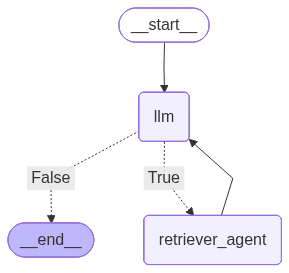

In [57]:
rag_agent = graph.compile()

rag_agent

## 📋 Các câu hỏi mẫu bạn có thể đặt cho RAG Agent

Dựa trên nội dung tài liệu Healthcare.pdf, đây là các loại câu hỏi bạn có thể hỏi:

### 🏥 Về ICE Platform và Medical IoT
- "What is ICE platform and how does it work?"
- "What is Medical Internet of Things (MIoT)?"
- "How does ICE platform help reduce medical errors?"
- "What are the benefits of Integrated Clinical Environment?"

### 🔄 Về Digital Transformation
- "What is digital transformation of healthcare value chain?"
- "How does healthcare digital transformation work?"
- "What are the challenges in healthcare digital transformation?"

### ⚕️ Về Medical Errors và Patient Safety
- "What are preventable medical errors?"
- "How can medical errors be reduced?"
- "What is the impact of medical errors on patient safety?"

### 📊 Về Healthcare Data và Interoperability
- "What is healthcare data interoperability?"
- "How do medical devices share data?"
- "What are the standards for medical device interoperability?"

### 🏛️ Về Healthcare Industry
- "What is the medical-industrial complex?"
- "What are the issues with healthcare as a commodity?"
- "How does healthcare differ from traditional business models?"

### 🔬 Về Medical Research và Topics
- "What is rheumatoid arthritis?"
- "What is CRISPR technology?"
- "What are healthcare-associated infections?"

### 👥 Về Authors và Background
- "Who are the authors of this document?"
- "What is the background of this healthcare research?"
- "What institutions are involved in this research?"

### 📚 Về References và Studies
- "What studies are cited about medical errors?"
- "What research is mentioned about healthcare spending?"
- "What are the key references in this document?"

**Lưu ý:** Bạn có thể hỏi bằng tiếng Anh hoặc tiếng Việt. Agent sẽ tự động tìm kiếm thông tin liên quan trong tài liệu.


In [58]:
def running_agent():
    while True:
        user_input = input("\nWhat is your question: ")
        if user_input.lower() in ["exit", "quit", '', None]:
            print("Exiting...")
            break
        
        print_user_input(user_input)
        result = rag_agent.invoke({"messages": [HumanMessage(content=user_input)]})
        
        # Get the final AI response (last message should be AIMessage)
        final_message = result["messages"][-1]
        if hasattr(final_message, "content"):
            print_ai_response(final_message.content)
        else:
            print_ai_response(str(final_message))

running_agent()


╭───────────────────────────────────────────────── 👤 User Input ─────────────────────────────────────────────────╮
│ What are preventable medical errors?                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

✅ Tool calls detected: 1 tool call(s)
   - Tool: retrieve_document, Args: {'query': 'preventable medical errors'}
🔧 Executing tool call: retrieve_document with args: {'query': 'preventable medical errors'}
✅ Tool call result length: 11063 characters
⚠️  No tool calls detected in response


╭──────────────────────────────────────────────── 🤖 AI Response ─────────────────────────────────────────────────╮
│ [{'type': 'text', 'text': "Preventable medical errors are a problem partly attributed to the medical-industrial │
│ complex's focus on profit, utilizing proprietary semantic data dictionaries, locked data interfaces, and        │
│ upselling services (Source: Document 1, 2, 3, 4, 5, 6, 7, 8, Page 24).\n\nAdditionally, these errors can arise  │
│ from a lack of patient safety processes. A key factor is the unintegrated nature of device-level data. Medical  │
│ devices often provide single, time-dependent data points without integration with other monitors. This data     │
│ segregation can lead to medical errors, often fatal, by hindering comprehensive physiological status updates    │
│ for patients in various settings (Source: Document 9, 10, Page 9). In the US, medical errors are a significant  │
│ cause of death (Source: Document 9, 10, Page 9).", 'extras': {'signature':                                      │
│ 'CsYFAXLI2nzosQF5/u3jLokQPta3ninZVfmrSTUUrnSfXVy1KewpH7kvTAPbdXgfY7gRdfoVn4Danyxuj7RmXaMkAt7qhfTJPJM64BD1G1OqKM │
│ aOMjnPdM6eG+EBQy/hRoQtkqT884sOg4DskQaEM+z/wSI9wPU0jR5qx/d3b1DXkRbRTWpNc06/zA0s0CPmo0ZidAkI8Ai0EptQeD3IBuzohqCkV │
│ YX7pIYus5Rn5pB51kNQ9L6vA7lexa1FqNhMfeyAB6JxTCllos9B8cWgvjeowz5cbFRAv6zVn+5iUHQRQGOYrvyp9qpSNAwB8pNBbiGipWsWIgiT │
│ RgPHxwpXPFsL7ZrguNeRUcJAcaDSXr22c49zMOJknmhwQXxBkdDEbVI0Dt0jhdhaEmrT5emI9rRAGgknsFcFlH1IH+JbeMcABhQq5df1dxoKYBA │
│ bM6VUlr7q9UAqkrkjJea1cAijsJw5SP8k3ktRXs7jHEh8Cv+OebC3N+CQlTJDsh3JzAexhZ8s4/3qc8lTqoXH6uKEz5WgkKujbVhI/5D2n+w6rb │
│ zs/1eZBqeWcZqNzPlVRset9zP+m99xKfxduszi7Epn1KzzbdA2rYZq8RalaKVcrM8fygUCB//Akt+ynerZZKgZeI4CK+May7tVrUFtpKb7j4uZk │
│ RaKFLp+pWRDlPKa+awJlxQrhP6kOSYn4wfrhCgm7zBJaMVqE2UQRrKhrS6sL2Aaa5d5B2WGUw1YYA+OxpIOHrMipgjcHhAlYTVmZZlwl5HqCuJ7 │
│ Dx0iLuK//28iTv3Xua6PKvtuFWQzJhVcKmPDBCaiquIehGEhttAseRAFUA7sn6rmU2vLAKkly8lzBcx2s4OPOR+8bNo+P8pOJmniB7sIa58X83k │
│ xqVl9Z/kD4/YwcDQvTw77neEHQ8s7ws80VPowfc+il4mQ10WlYjbxl9H8DPon7Bw='}}]                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── 👤 User Input ─────────────────────────────────────────────────╮
│ hình như hơi sai sai                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

⚠️  No tool calls detected in response


╭──────────────────────────────────────────────── 🤖 AI Response ─────────────────────────────────────────────────╮
│ [{'type': 'text', 'text': 'Bạn có thể cho mình biết cụ thể hơn là điều gì đang "sai sai" không? Mình ở đây để   │
│ giúp bạn tìm kiếm thông tin y tế chính xác từ cơ sở dữ liệu. Vui lòng đặt câu hỏi hoặc cho mình biết bạn muốn   │
│ tìm hiểu về vấn đề gì nhé.', 'extras': {'signature':                                                            │
│ 'CoQEAXLI2nwzwHTomJxhmuCrvIr3qUK3+PlkhtsH89l3JLJ2wYQc8nN/4PuBwE34h2yWxtg25/0/d50R3am6phpRTWlcfDD5PV9CE0h6SNfOk4 │
│ f8gPNVHxvfgX0tzzeklJa/MDzeTqgYazQ+uMECXTEtuAN6QFqDPE+NI0IhZFyfttibSWkYZd3PkgUgJ4ngiqKOhZbm9e6HtNY9dAnpnz5myvjny │
│ p5do/3+VJAT6x4Rs4GEaZdRzNU55pKge4Mi2s/U7b8LzbVtc2dMtA1xWZlCloAFiDtCkbTsz2zNv+mgs29Jyq2woQZUxhwJOxQRd1IeShdfSPQX │
│ byByu/3IOuXMa6qZTqWd1q4y1umeVYqenRK0s7OJfVz1Nu/7oKfYMbt7l+SU/uVu1zliTL6tJu2r8fGRLDrJyb8TXc3KNL8/+y+mb8VtipirW5c │
│ gJEn1ESwdK+MHSfCtQe2X+AQ2HMk/WEOF9yJ47U9acl2ZPV017SIncf6+J1jevn7sAzi1S1b88sz6xPMf2Ry5m+UEbS8mrFZD1OWB4THPDkhzQB │
│ PYO8y/ubfbi3vhRYFq0UavW5Uvt7dzpADM96Q9B3N0KQ/M7CL+j3teH+UBQRYKdq5VS0ddzup4+lb8oEZh6QmaFmEXWgAFL2t6s1QOwGgPyCkEB │
│ FFjnePhMQnGq1sgZb5N5Hhcp+z4'}}]                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── 👤 User Input ─────────────────────────────────────────────────╮
│ ai là tác giả vậy                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

✅ Tool calls detected: 1 tool call(s)
   - Tool: retrieve_document, Args: {'query': 'tác giả'}
🔧 Executing tool call: retrieve_document with args: {'query': 'tác giả'}
✅ Tool call result length: 10940 characters
⚠️  No tool calls detected in response


╭──────────────────────────────────────────────── 🤖 AI Response ─────────────────────────────────────────────────╮
│ [{'type': 'text', 'text': 'Tài liệu bạn cung cấp chứa nhiều tác giả từ các nghiên cứu và ấn phẩm khác nhau. Một │
│ số tác giả được đề cập bao gồm:\n\n*   **Minsky, Marvin** (1988) với tác phẩm "Society of the Mind".\n*         │
│ **Topol, E.J.** (2014) với "Individualized medicine from prewomb to tomb".\n*   **Song Li, Yangsheng Yu, Yinshi │
│ Yue, Zhixin Zhang và Kaihong Su** (2013) với "Microbial Infection and Rheumatoid Arthritis".\n*   **Tim Wang,   │
│ Haiyan Yu, Nicholas W. Hughes, Bingxu Liu, Arek Kendirli, Klara Klein, Walter W. Chen, Eric S. Lander, David M. │
│ Sabatini** (2017) với "Gene Essentiality Profiling Reveals Gene Networks and Synthetic Lethal Interactions with │
│ Oncogenic Ras".\n*   **McCammon, J.A., Gelin B.R., Karplus, M.** (1977) với "Dynamics of folded                 │
│ proteins".\n\nNếu bạn muốn biết tác giả của một phần cụ thể, vui lòng cung cấp thêm chi tiết.', 'extras':       │
│ {'signature':                                                                                                   │
│ 'Cp4CAXLI2nzQh1xfIXYeclEGbReO8hygEjP6eUt7/yuhtoV9iRYq4XAy2nrrMeWNZNHkH4JhA3PtapRan2VmCDq6vG7LVLHweFixQDgn0NOhk1 │
│ npZ0qgjc0D1yEuZhrbu2zcN1RhI5GIYjEY6eaflMMO6/9nYHpnR3dEEuJRmPoo5x3YllxqTJxaatCEsJcR9Kms2NPSXO3waPVea3i7q0x7ikZw6 │
│ /p9obEnwiUNFduNed1f5cpZOjd5j3kMwYvt8WzE+pKgZhRwKwn2LOxpQeyhBCxAskj6Pntt3vWb5MOr/1i7Gf6NEmFHZOvLxzOCy+3mbNVHTkav │
│ CSnNVWmpxOEPCyIjoQ9fAuEyxtki8NzuGrF1IhDNjy4kJiDpSMooGg=='}}]                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── 👤 User Input ─────────────────────────────────────────────────╮
│ thôi dừng                                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

⚠️  No tool calls detected in response


╭──────────────────────────────────────────────── 🤖 AI Response ─────────────────────────────────────────────────╮
│ [{'type': 'text', 'text': 'Dừng lại. Tôi có thể giúp gì thêm không?', 'extras': {'signature':                   │
│ 'CpoBAXLI2nxl25LnoNf2JHWzK3cKQHnu4umjfVcJGSezXGJLfJSR0IyjPZOyEcAwWCRbdXDRiVY8w/DeqcVewAoUqW7rrc0xj20hakXqPeX/uP │
│ FIlXV90gk5O00zH8G++yUAKxrPQpG6ajFzlyBld+rPa+1dtzHIi88ecSP1kACtPQYUWPSEHdsfviP0m3Q3ZXFIDu0BHFxRApKfww=='}}]      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Exiting...
